# Q2:
## Is there a relationship between Quantity and Reorder level

In [91]:
from importlib import reload

import helper_functions as hf

import pandas as pd
import numpy as np

import sqlite3
import scipy.stats as scs

from statsmodels.stats.power import tt_ind_solve_power

import matplotlib.pyplot as plt
import seaborn as sns

reload(hf)

<module 'helper_functions' from '/Users/rafael/flatiron-dsc/curriculum-v2/mod-3-project/dsc-mod-3-project-data-science/helper_functions.py'>

In [4]:
conn, cursor = hf.create_connection()

In [10]:
hf.list_tables(cursor=cursor)

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

### Investiation of Product Table

In [14]:
product_df = hf.load_table_as_dataframe(conn, "Product")
product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [15]:
product_df.ReorderLevel.unique()

array([10, 25,  0, 30,  5, 15, 20])

In [17]:
order_detail_df = hf.load_table_as_dataframe(conn, "OrderDetail")
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


-----

### Join product information with order details to get data I need for testing

-----

In [18]:
query = """select od.OrderId, od.ProductId, od.UnitPrice, 
                  od.Quantity, od.Discount, p.ReorderLevel, p.ProductName
           from orderdetail as od
           join product as p
           where p.Id = od.ProductId;"""

In [19]:
joined_df = pd.read_sql(query, conn)
joined_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ReorderLevel,ProductName
0,10248,11,14.0,12,0.0,30,Queso Cabrales
1,10248,42,9.8,10,0.0,0,Singaporean Hokkien Fried Mee
2,10248,72,34.8,5,0.0,0,Mozzarella di Giovanni
3,10249,14,18.6,9,0.0,0,Tofu
4,10249,51,42.4,40,0.0,10,Manjimup Dried Apples


In [22]:
# feature engineer a has_discount column
joined_df['has_discount'] = joined_df.Discount.apply(lambda x: 1 if x > 0 else 0)
joined_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ReorderLevel,ProductName,has_discount
0,10248,11,14.0,12,0.0,30,Queso Cabrales,0
1,10248,42,9.8,10,0.0,0,Singaporean Hokkien Fried Mee,0
2,10248,72,34.8,5,0.0,0,Mozzarella di Giovanni,0
3,10249,14,18.6,9,0.0,0,Tofu,0
4,10249,51,42.4,40,0.0,10,Manjimup Dried Apples,0


### Some basic EDA with ViolinPlots

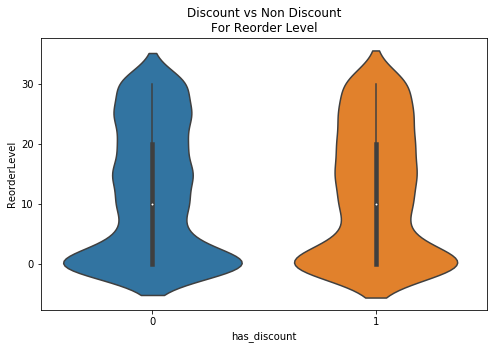

In [23]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='has_discount', y='ReorderLevel', data=joined_df)
plt.title("Discount vs Non Discount\nFor Reorder Level")
plt.show()

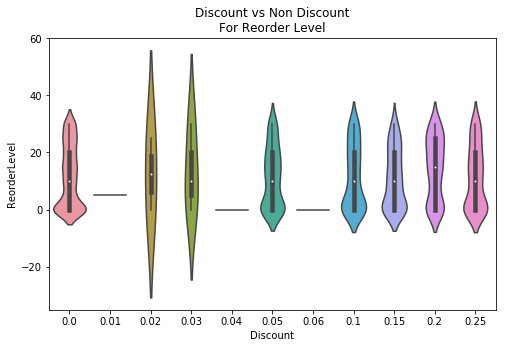

In [24]:
# Let's do another violin plot but by discount level
plt.figure(figsize=(8, 5))
sns.violinplot(x='Discount', y='ReorderLevel', data=joined_df)
plt.title("Discount vs Non Discount\nFor Reorder Level")
plt.show()

In [26]:
joined_df.groupby(by='Discount')['ReorderLevel'].describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,11.856492,10.839948,0.0,0.00,10.0,20.00,30.0
0.01,1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0
0.02,2.0,12.500000,17.677670,0.0,6.25,12.5,18.75,25.0
0.03,3.0,13.333333,15.275252,0.0,5.00,10.0,20.00,30.0
0.04,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
0.05,185.0,11.540541,10.474074,0.0,0.00,10.0,20.00,30.0
0.06,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
0.10,173.0,11.618497,11.035572,0.0,0.00,10.0,20.00,30.0
0.15,157.0,11.019108,10.186386,0.0,0.00,10.0,20.00,30.0


In [28]:
discount_categories = []
for d in joined_df.Discount:
    if d == 0:
        discount_categories.append("Zero")
        continue
    if d <= 0.10:
        discount_categories.append("0 to 10")
        continue
    if d > 0.10:
        discount_categories.append("10 to 25")
        continue
joined_df["discount_category"] = discount_categories
joined_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ReorderLevel,ProductName,has_discount,discount_category
0,10248,11,14.0,12,0.0,30,Queso Cabrales,0,Zero
1,10248,42,9.8,10,0.0,0,Singaporean Hokkien Fried Mee,0,Zero
2,10248,72,34.8,5,0.0,0,Mozzarella di Giovanni,0,Zero
3,10249,14,18.6,9,0.0,0,Tofu,0,Zero
4,10249,51,42.4,40,0.0,10,Manjimup Dried Apples,0,Zero


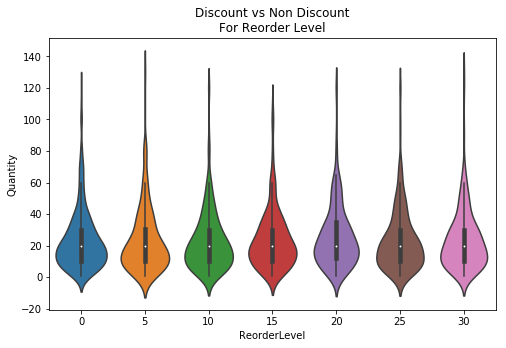

In [36]:
# Let's do another violin plot but by discount level
plt.figure(figsize=(8, 5))
sns.violinplot(x='ReorderLevel', y='Quantity', data=joined_df)
plt.title("Discount vs Non Discount\nFor Reorder Level")
plt.show()

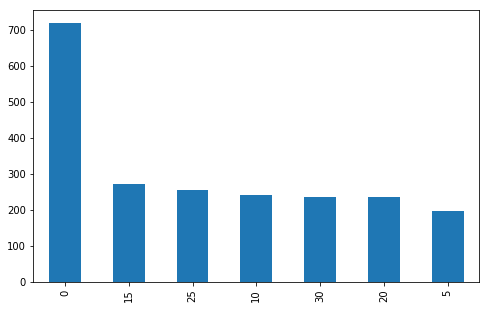

In [38]:
# let's plot a bar graph of reorder levels
joined_df.ReorderLevel.value_counts().plot(kind='bar', figsize=(8, 5))

In [42]:
# let's just compare reorder level 0 to everything else
quant_reord_0 = joined_df.loc[joined_df.ReorderLevel==0, 'Quantity']
quant_reord_g0 = joined_df.loc[joined_df.ReorderLevel>0, 'Quantity']

In [43]:
hf.test_normality(quant_reord_0)

p = 1.4225978601085515e-25
Therefore the data is not normal


False

In [44]:
hf.test_normality(quant_reord_g0)

p = 9.621526872301005e-35
Therefore the data is not normal


False

### Since data isn't normal, let's take a sampling distribution

In [81]:
samp_dis_qr0 = hf.get_sampling_distribution(quant_reord_0, number_of_samples=50)
samp_dis_qrg0 = hf.get_sampling_distribution(quant_reord_g0, number_of_samples=50)

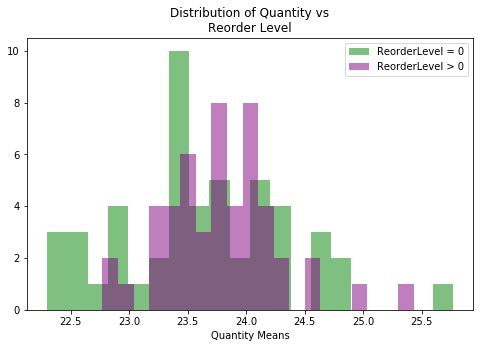

In [82]:
plt.figure(figsize=(8, 5))
plt.hist(samp_dis_qr0, bins=20, alpha=0.5, color='g', label='ReorderLevel = 0')
plt.hist(samp_dis_qrg0, bins=20, alpha=0.5, color='purple', label='ReorderLevel > 0')
plt.legend()
plt.title("Distribution of Quantity vs\nReorder Level")
plt.xlabel("Quantity Means")
plt.show()

### Let's test for normality on our sampling distribution

In [83]:
hf.test_normality(samp_dis_qr0)

p = 0.5250665545463562
Therefore the data is normal


True

In [84]:
hf.test_normality(samp_dis_qrg0)

p = 0.13863636553287506
Therefore the data is normal


True

### Test for equal variances

In [85]:
hf.test_equal_variances(samp_dis_qr0, samp_dis_qrg0)

p = 0.016948340247885763
Therefore the data do not have equal variances


False

### Our data 
- Is normal
- Has unequal variances

Therefore I will use
- Welch's Ttest


H0: mu1 = mu2

HA: mu1 != mu2

In [86]:
scs.ttest_ind(samp_dis_qr0, samp_dis_qrg0, equal_var=False)

Ttest_indResult(statistic=-1.2892896346794933, pvalue=0.20074031291579444)

### Conclusion

Given a p-value of 0.72 we can conclude that there is no difference between the mean quantity ordered based on ReorderLevel. 


### Further Testing 

- What is the effect size? 
- What is the power? 

In [87]:
effect_size = hf.cohen_d(samp_dis_qrg0, samp_dis_qr0)
effect_size

0.2578579269358987

In [89]:
power = tt_ind_solve_power(effect_size=effect_size, nobs1=len(samp_dis_qr0), alpha=0.05)
power

0.2478159155455689

### Findings
- Our ttest showed that there is no difference between mean quantity across Reorder Levels. 

- Our power is 0.06, which means have a type II error rate of 0.94

There is not relationship between these two features in our data. 

### What did we learn?
- A finding is a finding
- Creating a helper_functions file
    - Using reload
- I learned the difference between Welches T Test and Student T Test. We use Welches when we have unequal variances and assume normality. But student T test we use when we have equal variances and also assume normality.